## Importing Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
from scipy import stats
import keras
from matplotlib import pyplot
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.pipeline import make_pipeline
# Initialize seaborn (for plotting)
sns.set()

# Part 1

## Loading and Inspecting Data

In [3]:
#player sample
dfPlayer= pd.read_csv('player_sample.csv')
dfPlayer

,Age,Previous App Purchases,Price
0,37,218,6.0
1,34,247,6.0
2,19,15,4.0
3,32,235,7.0
4,19,15,2.5
...,...,...,...
9995,31,241,NaN
9996,25,265,NaN
9997,25,259,NaN
9998,68,115,NaN


In [4]:
pricecount=dfPlayer.groupby('Price').count()
pricecount = pricecount.reset_index()
pricecount= pricecount.rename(columns={"Age": "Demand"})
pricecount= pricecount.drop(['Previous App Purchases'], axis=1)
pricecount

,Price,Demand
0,2.0,376
1,2.5,124
2,3.0,72
3,4.0,59
4,5.0,185
5,6.0,1173
6,7.0,479
7,8.0,34
8,9.0,30
9,10.0,21


In [5]:
counts=[]
dfWillingness=pricecount.copy()

for i in pricecount["Price"]:
    counts.append(pricecount.loc[pricecount['Price']>= i,'Demand'].sum())

dfWillingness.insert(2,'Willingness Count ',counts)

In [6]:
dfWillingness

,Price,Demand,Willingness Count
0,2.0,376,2932
1,2.5,124,2556
2,3.0,72,2432
3,4.0,59,2360
4,5.0,185,2301
5,6.0,1173,2116
6,7.0,479,943
7,8.0,34,464
8,9.0,30,430
9,10.0,21,400


In [7]:
dfWillingness['PercentWilling']=dfWillingness["Willingness Count "]/10000
#dfWillingness['PercentWilling']=1-dfWillingness["PercentWilling"]

In [8]:
dfWillingness

,Price,Demand,Willingness Count,PercentWilling
0,2.0,376,2932,0.2932
1,2.5,124,2556,0.2556
2,3.0,72,2432,0.2432
3,4.0,59,2360,0.2360
4,5.0,185,2301,0.2301
5,6.0,1173,2116,0.2116
6,7.0,479,943,0.0943
7,8.0,34,464,0.0464
8,9.0,30,430,0.0430
9,10.0,21,400,0.0400


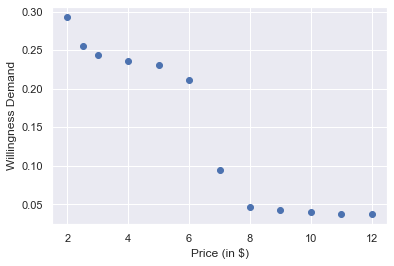

In [9]:
# Scatter plot
plt.scatter(dfWillingness["Price"], dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

## Parametric Approach

## Fitting a Function

In [186]:
# First argument is the independent variable, others are the function parameters
def curve_to_fit(p, a, b, c):
    return (c * np.exp(-1*(a+b*p))/(1+ (np.exp(-1*(a+b*p)))))

In [187]:
# Find the curve that best fits data (based on least squares)

from scipy import optimize

# suggested function parameters (any initial hint you may have)
initial_p = [-1, 0,2000]

# fit curve
params, cov = optimize.curve_fit(curve_to_fit, dfWillingness["Price"], dfWillingness["PercentWilling"], initial_p, maxfev=10000)

# parameters
params

array([-5.30484668,  0.79280791,  0.27651288])

a: -5.304846683487298
b: 0.7928079051297443
c 0.27651287508130956


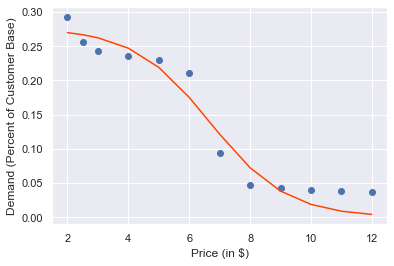

In [188]:
# Plotting all together to see how it looks

a,b,c = params
y_fit = [ curve_to_fit(p, a, b,c) for p in dfWillingness["Price"]]

print("a:",a)
print("b:",b)
print("c",c)

plt.plot(dfWillingness["Price"], y_fit, color="orangered")
plt.scatter(dfWillingness["Price"], dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Demand (Percent of Customer Base)")
plt.show()

## Single Price Maximization

In [189]:
#potential prices set
prices= np.arange(2.0,12.01,0.01)

prices

array([ 2.  ,  2.01,  2.02, ..., 11.98, 11.99, 12.  ])

In [14]:
demand = {}
for i in prices:
    demand[i] = float(curve_to_fit(i,a,b,c)*2000000.00)
demand

{2.0: 539931.011743388,
 2.01: 539829.2701412179,
 2.0199999999999996: 539726.7575125468,
 2.0299999999999994: 539623.4683179104,
 2.039999999999999: 539519.3969827804,
 2.049999999999999: 539414.5378974181,
 2.0599999999999987: 539308.885416728,
 2.0699999999999985: 539202.4338601123,
 2.0799999999999983: 539095.177511327,
 2.089999999999998: 538987.1106183361,
 2.099999999999998: 538878.2273931706,
 2.1099999999999977: 538768.5220117843,
 2.1199999999999974: 538657.9886139134,
 2.1299999999999972: 538546.6213029358,
 2.139999999999997: 538434.4141457303,
 2.149999999999997: 538321.3611725396,
 2.1599999999999966: 538207.4563768309,
 2.1699999999999964: 538092.6937151604,
 2.179999999999996: 537977.0671070362,
 2.189999999999996: 537860.5704347852,
 2.1999999999999957: 537743.1975434185,
 2.2099999999999955: 537624.9422404995,
 2.2199999999999953: 537505.7982960125,
 2.229999999999995: 537385.7594422328,
 2.239999999999995: 537264.8193735983,
 2.2499999999999947: 537142.9717465821,
 2

In [15]:
revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)
revenue

{2.0: 1079862.023486776,
 2.01: 1085056.8329838477,
 2.0199999999999996: 1090248.0501753443,
 2.0299999999999994: 1095435.6406853579,
 2.039999999999999: 1100619.5698448715,
 2.049999999999999: 1105799.8026897067,
 2.0599999999999987: 1110976.303958459,
 2.0699999999999985: 1116149.0380904318,
 2.0799999999999983: 1121317.9692235591,
 2.089999999999998: 1126483.0611923214,
 2.099999999999998: 1131644.277525657,
 2.1099999999999977: 1136801.5814448635,
 2.1199999999999974: 1141954.935861495,
 2.1299999999999972: 1147104.3033752516,
 2.139999999999997: 1152249.6462718614,
 2.149999999999997: 1157390.9265209585,
 2.1599999999999966: 1162528.105773953,
 2.1699999999999964: 1167661.1453618961,
 2.179999999999996: 1172790.0062933369,
 2.189999999999996: 1177914.6492521774,
 2.1999999999999957: 1183035.0345955184,
 2.2099999999999955: 1188151.1223515016,
 2.2199999999999953: 1193262.872217145,
 2.229999999999995: 1198370.2435561765,
 2.239999999999995: 1203473.1953968576,
 2.2499999999999947:

In [16]:
max_revenue = max(revenue, key=revenue.get)
print("Optimal Price:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price: 5.24
Maximum value: 2201234.67


## Different Prices Per Player

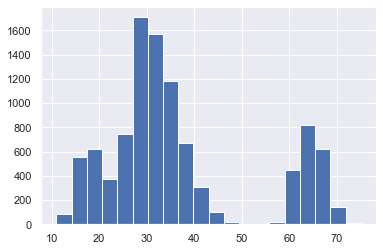

In [17]:
plt.hist(dfPlayer['Age'],20)
plt.show()

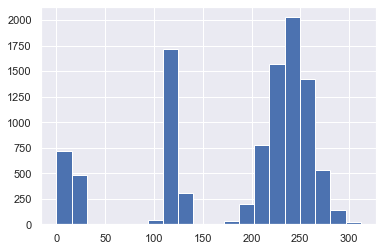

In [18]:
plt.hist(dfPlayer['Previous App Purchases'],20)
plt.show()

In [19]:
df=dfPlayer.copy()
df=df.drop(columns=['Price'])

In [20]:
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(df)
#Converting the numpy array into a pandas DataFrame
scaled_df = pd.DataFrame(scaled_df)
scaled_df.head(5)

,0,1
0,0.406250,0.698718
1,0.359375,0.791667
2,0.125000,0.048077
3,0.328125,0.753205
4,0.125000,0.048077


In [21]:
scaled_df.columns=['Age','Previous App Purchases']

In [22]:
x_array = scaled_df.values
x_array

array([[0.40625   , 0.69871795],
       [0.359375  , 0.79166667],
       [0.125     , 0.04807692],
       ...,
       [0.21875   , 0.83012821],
       [0.890625  , 0.36858974],
       [0.765625  , 0.40064103]])

In [23]:
ks = range(1,10)
inertias = []
centroids = []
scaler = StandardScaler()

In [24]:
for k in ks:
    model = KMeans(n_clusters = k)
    pipeline = make_pipeline(scaler,model)
    pipeline.fit(scaled_df)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)
    centroids.append(pipeline.named_steps['kmeans'].cluster_centers_)

([<matplotlib.axis.XTick at 0x21b194ad6a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

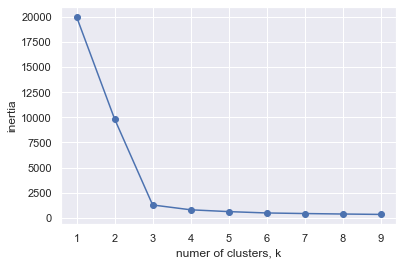

In [25]:
plt.plot(ks, inertias, '-o')
plt.xlabel('numer of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

## 3 Clusters

In [270]:
import random
model=KMeans(n_clusters=3, random_state = 42)

In [271]:
model.fit(scaled_df)

KMeans(n_clusters=3, random_state=42)

In [272]:
labels=model.predict(scaled_df)
labels

array([0, 0, 1, ..., 0, 2, 2])

In [273]:
#add labels to original data set
clusterdf=dfPlayer.copy()
clusterdf['label']=labels
clusterdf

,Age,Previous App Purchases,Price,label
0,37,218,6.0,0
1,34,247,6.0,0
2,19,15,4.0,1
3,32,235,7.0,0
4,19,15,2.5,1
...,...,...,...,...
9995,31,241,NaN,0
9996,25,265,NaN,0
9997,25,259,NaN,0
9998,68,115,NaN,2


In [274]:
#filter rows of original data
group0 = clusterdf[clusterdf['label'] == 0]
group1 = clusterdf[clusterdf['label'] == 1]
group2 = clusterdf[clusterdf['label'] == 2]
 

In [280]:
print(len(group0))
print(len(group1))
print(len(group2))

6732
1200
2068


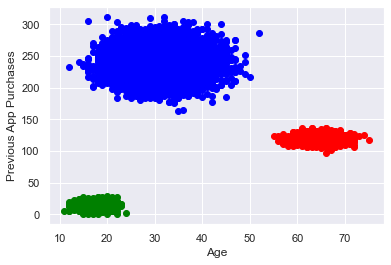

In [281]:
#Plotting the results
plt.scatter(group0['Age'] , group0['Previous App Purchases'] , color = 'blue')
plt.scatter(group1['Age'] , group1['Previous App Purchases'] , color = 'green')
plt.scatter(group2['Age'] , group2['Previous App Purchases'] , color = 'red')
plt.xlabel('Age')
plt.ylabel('Previous App Purchases')
plt.show()

###  Customers with the Most App Purchases (10-50 Year Olds)

In [311]:
def curve_to_fit_1(p, a, b, c):
    return (c * np.exp(-1*(a+b*p))/(1+ (np.exp(-1*(a+b*p)))))

In [312]:
group0pricecount=group0.groupby('Price').count()
group0pricecount = group0pricecount.reset_index()
group0pricecount= group0pricecount.rename(columns={"Age": "Demand"})
group0pricecount= group0pricecount.drop(['Previous App Purchases'], axis=1)

counts=[]
group0dfWillingness=group0pricecount.copy()

for i in group0pricecount["Price"]:
    counts.append(group0pricecount.loc[group0pricecount['Price']>= i,'Demand'].sum())

group0dfWillingness.insert(2,'Willingness Count ',counts)

group0dfWillingness['PercentWilling']=group0dfWillingness["Willingness Count "]/len(group0)

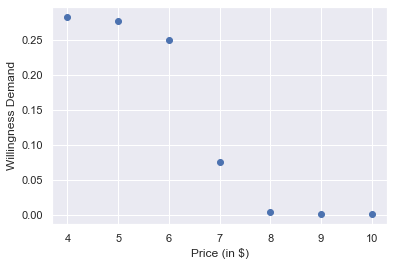

In [313]:
# Scatter plot
plt.scatter(group0dfWillingness["Price"], group0dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

In [314]:
# Find the curve that best fits data (based on least squares)

from scipy import optimize

# suggested function parameters (any initial hint you may have)
initial_p = [-1, 0,2000]

# fit curve
params, cov = optimize.curve_fit(curve_to_fit_1, group0dfWillingness["Price"], group0dfWillingness["PercentWilling"], initial_p)

# parameters
params

array([-20.34051036,   3.0472636 ,   0.28048861])

a: -20.34051035839258
b: 3.0472636034931058
c 0.280488611596928


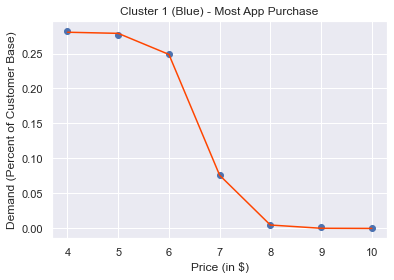

In [315]:
# Plotting all together to see how it looks

a1,b1,c1 = params
y_fit = [ curve_to_fit_1(p, a1, b1,c1) for p in group0dfWillingness["Price"]]

print("a:",a1)
print("b:",b1)
print("c",c1)

plt.plot(group0dfWillingness["Price"], y_fit, color="orangered")
plt.scatter(group0dfWillingness["Price"], group0dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Demand (Percent of Customer Base)")
plt.title('Cluster 1 (Blue) - Most App Purchase')
plt.show()

In [287]:
#potential prices set
prices= np.arange(2.0,12.01,0.01)

demand = {}
for i in prices:
    demand[i] = float(curve_to_fit_1(i,a1,b1,c1)*2000000.00* len(group0)/10000)

revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)

max_revenue = max(revenue, key=revenue.get)
print("Optimal Price for Teens:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price for Teens: 5.75
Maximum value: 2049189.43


### Children with Minimal Purchases

In [288]:
group1pricecount=group1.groupby('Price').count()
group1pricecount = group1pricecount.reset_index()
group1pricecount= group1pricecount.rename(columns={"Age": "Demand"})
group1pricecount= group1pricecount.drop(['Previous App Purchases'], axis=1)

counts=[]
group1dfWillingness=group1pricecount.copy()

for i in group1pricecount["Price"]:
    counts.append(group1pricecount.loc[group1pricecount['Price']>= i,'Demand'].sum())

group1dfWillingness.insert(2,'Willingness Count ',counts)

group1dfWillingness['PercentWilling']=group1dfWillingness["Willingness Count "]/len(group1)

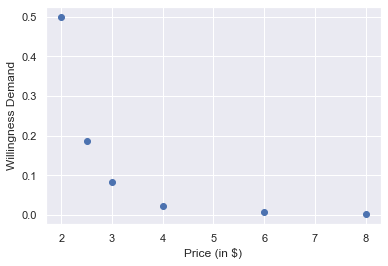

In [289]:
# Scatter plot
plt.scatter(group1dfWillingness["Price"], group1dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

In [290]:
# First argument is the independent variable, others are the function parameters
def curve_to_fit_2(x, a, b):
    return (a * (x ** b))

In [316]:
# Find the curve that best fits data (based on least squares)

from scipy import optimize


# fit curve
params, cov = optimize.curve_fit(curve_to_fit_2, group1dfWillingness["Price"], group1dfWillingness["PercentWilling"])

# parameters
params

array([10.63023889, -4.41035229])

a: 10.630238885238994
b: -4.410352290585862


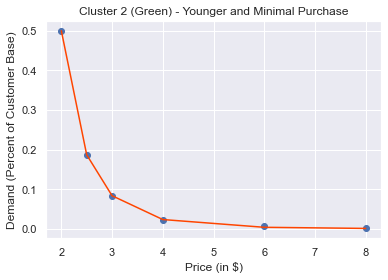

In [317]:
# Plotting all together to see how it looks

a2,b2 = params
y_fit = [ curve_to_fit_2(p, a2, b2) for p in group1dfWillingness["Price"]]

print("a:",a2)
print("b:",b2)

plt.plot(group1dfWillingness["Price"], y_fit, color="orangered")
plt.scatter(group1dfWillingness["Price"], group1dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Demand (Percent of Customer Base)")
plt.title('Cluster 2 (Green) - Younger and Minimal Purchase')
plt.show()

In [293]:
#potential prices set
prices= np.arange(2.0,12.01,0.01)

demand = {}
for i in prices:
    demand[i] = float(curve_to_fit_2(i,a2,b2)*2000000.00 * len(group1)/10000)

revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)

max_revenue = max(revenue, key=revenue.get)
print("Optimal Price for Teens:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price for Teens: 2.0
Maximum value: 239958.39


### Older Generation With Average Number of Purchases

In [318]:
group2pricecount=group2.groupby('Price').count()
group2pricecount = group2pricecount.reset_index()
group2pricecount= group2pricecount.rename(columns={"Age": "Demand"})
group2pricecount= group2pricecount.drop(['Previous App Purchases'], axis=1)

counts=[]
group2dfWillingness=group2pricecount.copy()

for i in group2dfWillingness["Price"]:
    counts.append(group2pricecount.loc[group2pricecount['Price']>= i,'Demand'].sum())

group2dfWillingness.insert(2,'Willingness Count ',counts)

group2dfWillingness['PercentWilling']=group2dfWillingness["Willingness Count "]/len(group2)

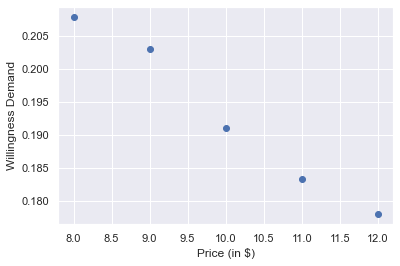

In [319]:
# Scatter plot
plt.scatter(group2dfWillingness["Price"], group2dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

In [296]:
# First argument is the independent variable, others are the function parameters
def curve_to_fit_3(x, a, b):
    return (a - (x * b))

In [321]:
# Find the curve that best fits data (based on least squares)

from scipy import optimize


# fit curve
params, cov = optimize.curve_fit(curve_to_fit_3, group2dfWillingness["Price"], group2dfWillingness["PercentWilling"])

# parameters
params

array([0.27243714, 0.00797872])

a: 0.272437137329154
b: 0.007978723402090493


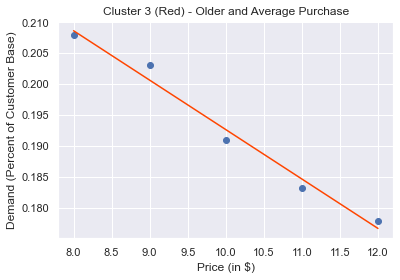

In [322]:
# Plotting all together to see how it looks

a3,b3 = params
y_fit = [ curve_to_fit_3(p, a3, b3) for p in group2dfWillingness["Price"]]

print("a:",a3)
print("b:",b3)

plt.plot(group2dfWillingness["Price"], y_fit, color="orangered")
plt.scatter(group2dfWillingness["Price"], group2dfWillingness["PercentWilling"])
plt.xlabel("Price (in $)")
plt.ylabel("Demand (Percent of Customer Base)")
plt.title('Cluster 3 (Red) - Older and Average Purchase')
plt.show()

In [299]:
#potential prices set
prices= np.arange(2.0,12.01,0.01)

demand = {}
for i in prices:
    demand[i] = float(curve_to_fit_3(i,a3,b3)*2000000.00* len(group2)/10000)

revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)

max_revenue = max(revenue, key=revenue.get)
print("Optimal Price for Older Folks:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price for Older Folks: 12.0
Maximum value: 876960.0


In [300]:
876960.0+239958.39+2049189.44

3166107.83

## Non-Parametric Approach

### Single Price for All

In [251]:
nonparamdf=dfPlayer.copy()
nonparamdf['Willingness']=nonparamdf['Price'].fillna(value=0)

In [252]:
#potential prices set
prices= np.arange(2.0,13.0,1.0)

demand = {}
for i in prices:
    demand[i] = (1-sum(nonparamdf['Willingness']<i)/10000)*2000000

revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)

In [253]:
revenue

{2.0: 1172800.0,
 3.0: 1459199.9999999998,
 4.0: 1888000.0,
 5.0: 2300999.9999999995,
 6.0: 2539200.0,
 7.0: 1320200.0000000007,
 8.0: 742400.0,
 9.0: 774000.0000000007,
 10.0: 800000.0000000007,
 11.0: 833800.0000000009,
 12.0: 883200.0000000014}

In [254]:
demand

{2.0: 586400.0,
 3.0: 486399.99999999994,
 4.0: 472000.0,
 5.0: 460199.99999999994,
 6.0: 423200.0,
 7.0: 188600.0000000001,
 8.0: 92800.0,
 9.0: 86000.00000000007,
 10.0: 80000.00000000007,
 11.0: 75800.00000000009,
 12.0: 73600.00000000012}

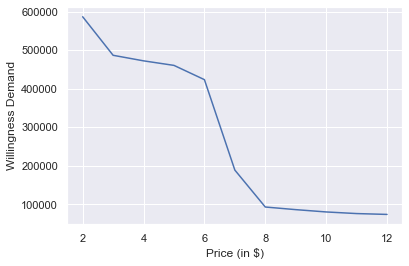

In [255]:
# Scatter plot
plt.plot(prices, demand.values())
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

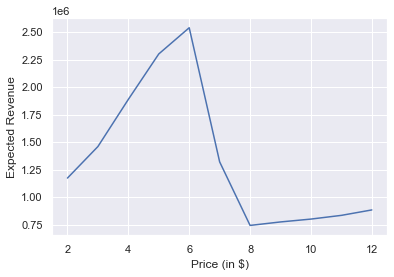

In [256]:
# Scatter plot
plt.plot(prices, revenue.values())
plt.xlabel("Price (in $)")
plt.ylabel("Expected Revenue")
plt.show()

In [257]:
max_revenue = max(revenue, key=revenue.get)
print("Optimal Price for All:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price for All: 6.0
Maximum value: 2539200.0


## Price Per Cluster

## 3 Clusters

In [258]:
import random
model=KMeans(n_clusters=3, random_state = 42)

In [259]:
model.fit(scaled_df)

KMeans(n_clusters=3, random_state=42)

In [260]:
labels=model.predict(scaled_df)
labels

array([0, 0, 1, ..., 0, 2, 2])

In [261]:
#add labels to original data set
clusterdf=dfPlayer.copy()
clusterdf['label']=labels
clusterdf

,Age,Previous App Purchases,Price,label
0,37,218,6.0,0
1,34,247,6.0,0
2,19,15,4.0,1
3,32,235,7.0,0
4,19,15,2.5,1
...,...,...,...,...
9995,31,241,NaN,0
9996,25,265,NaN,0
9997,25,259,NaN,0
9998,68,115,NaN,2


In [262]:
#filter rows of original data
group0 = clusterdf[clusterdf['label'] == 0]
group1 = clusterdf[clusterdf['label'] == 1]
group2 = clusterdf[clusterdf['label'] == 2]


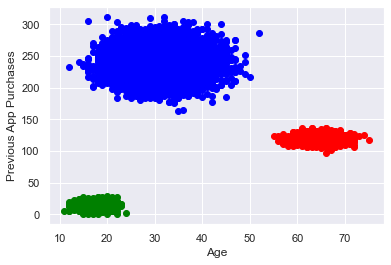

In [263]:
#Plotting the results
plt.scatter(group0['Age'] , group0['Previous App Purchases'] , color = 'blue')
plt.scatter(group1['Age'] , group1['Previous App Purchases'] , color = 'green')
plt.scatter(group2['Age'] , group2['Previous App Purchases'] , color = 'red')
plt.xlabel('Age')
plt.ylabel('Previous App Purchases')
plt.show()

In [264]:
group0['Willingness']=group0['Price'].fillna(value=0)
group1['Willingness']=group1['Price'].fillna(value=0)
group2['Willingness']=group2['Price'].fillna(value=0)

C:\Users\admin\AppData\Local\Temp/ipykernel_25060/1404565930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group0['Willingness']=group0['Price'].fillna(value=0)
C:\Users\admin\AppData\Local\Temp/ipykernel_25060/1404565930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['Willingness']=group1['Price'].fillna(value=0)
C:\Users\admin\AppData\Local\Temp/ipykernel_25060/1404565930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [265]:
group0length=group0.shape[0]
group1length=group1.shape[0]
group2length=group2.shape[0]

###  Customers with the Most App Purchases (10-50 Year Olds)

In [266]:
#potential prices set
prices= np.arange(2.0,13.0,1.0)

demand = {}
for i in prices:
    demand[i] = (1-sum(group0['Willingness']<i)/group0length)*2000000

revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)

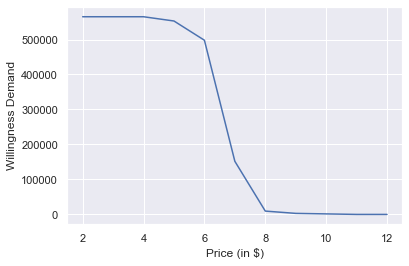

In [267]:
# Scatter plot
plt.plot(prices, demand.values())
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

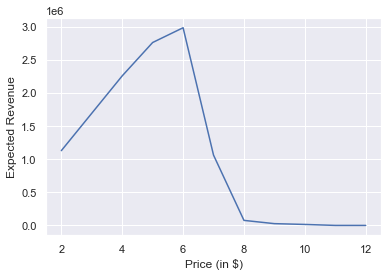

In [268]:
# Scatter plot
plt.plot(prices, revenue.values())
plt.xlabel("Price (in $)")
plt.ylabel("Expected Revenue")
plt.show()

In [269]:
max_revenue = max(revenue, key=revenue.get)
print("Optimal Price for All:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price for All: 6.0
Maximum value: 2987522.28


### Children with Minimal Purchases

In [674]:
#potential prices set
prices= np.arange(2.0,13.0,1.0)

demand = {}
for i in prices:
    demand[i] = (1-sum(group1['Willingness']<i)/group1length)*2000000

revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)

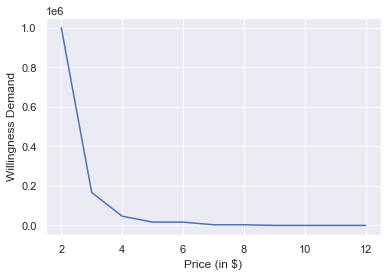

In [675]:
# Scatter plot
plt.plot(prices, demand.values())
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

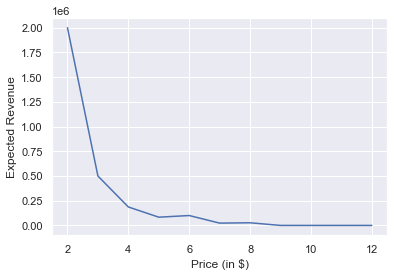

In [676]:
# Scatter plot
plt.plot(prices, revenue.values())
plt.xlabel("Price (in $)")
plt.ylabel("Expected Revenue")
plt.show()

In [677]:
max_revenue = max(revenue, key=revenue.get)
print("Optimal Price for All:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price for All: 2.0
Maximum value: 2000000.0


### Older Generation With Average Number of Purchases

In [678]:
#potential prices set
prices= np.arange(2.0,13.0,1.0)

demand = {}
for i in prices:
    demand[i] = (1-sum(group2['Willingness']<i)/group2length)*2000000

revenue= {}
for i in prices:
    revenue[i] = float(demand[i]*i)

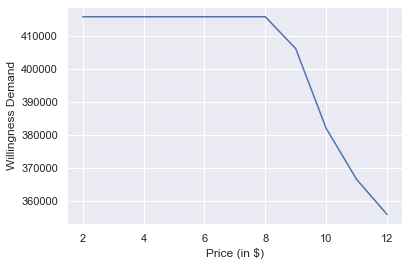

In [679]:
# Scatter plot
plt.plot(prices, demand.values())
plt.xlabel("Price (in $)")
plt.ylabel("Willingness Demand")
plt.show()

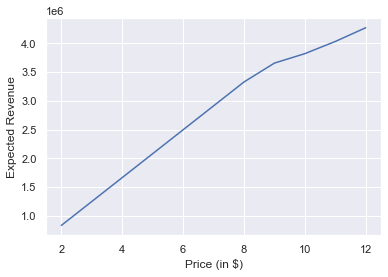

In [680]:
# Scatter plot
plt.plot(prices, revenue.values())
plt.xlabel("Price (in $)")
plt.ylabel("Expected Revenue")
plt.show()

In [681]:
max_revenue = max(revenue, key=revenue.get)
print("Optimal Price for All:",round(max_revenue,2))
print("Maximum value:",round(revenue[max_revenue],2))

Optimal Price for All: 12.0
Maximum value: 4270793.04


# Part 2 

(segments and fitted curves from part one in parametric approach will be used in part 2)

## Different Discounts

### Sets

In [237]:
#potential prices set
prices= np.round(np.arange(0.01,12.01,0.01), 2)

#accept_probability
accept_probability1 = {}
for i in prices:
    accept_probability1[i] = float(curve_to_fit_1(i,a1,b1,c1))
    
accept_probability2 = {}
for i in prices:
    accept_probability2[i] = float(curve_to_fit_2(i,a2,b2))
    
accept_probability3 = {}
for i in prices:
    accept_probability3[i] = float(curve_to_fit_3(i,a3,b3))
    
def getAcceptProb(price, segment):
    """find demand based on price and segment"""
    if segment == 1:
        return accept_probability1[price]
    elif segment == 2:
        return accept_probability2[price]
    else:
        return accept_probability3[price]
    
#segments
segments = [1,2,3]

#days
days = [1,2]

#base prices
# base_prices = [5.75, 2, 12]
base_prices = list(np.round(np.arange(2,13,1), 2))

#discounts - percentage
discounts = np.round(np.arange(0.05, 1, 0.05), 2)

In [238]:
accept_probability1[7] * 118248

8983.206172292537

In [239]:
base_prices

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [240]:
#calculate # of customers in each segment interested in the event
customer_count_group = {}
customer_count_group[1] = len(group0) / 10000 * 2000000 * 0.1
customer_count_group[2] = len(group1) / 10000 * 2000000 * 0.1
customer_count_group[3] = len(group2) / 10000 * 2000000 * 0.1
customer_count_group

{1: 134640.0, 2: 24000.0, 3: 41360.0}

### Variables

In [241]:
def create_variables():
    
    #variables: number of offers sent to segment i in day t
    xvar = pulp.LpVariable.dict("x", (segments, days), lowBound=0.0, cat=pulp.LpContinuous)
    
    return xvar

### Model Initialization

In [242]:
#initialie model
def initiatize_model():
    Model = pulp.LpProblem(name="Different Discounts Solution", sense=pulp.LpMaximize)
    return Model

### Constraints

In [243]:
def add_constraints(baseprice, discountrates, Model):
    #Constraint: total number of accepted offers <= 10,000 on each day
    for t in days:
        Model += pulp.lpSum(xvar[(i, t)]*getAcceptProb(np.round((1-discountrates[i])*baseprice,2), i) for i in segments) <= 10000

    #Constraint: total # of offer sent in each segment <= number of people in each segment
    for i in segments:
        Model += pulp.lpSum(xvar[(i, t)] for t in days) <= customer_count_group[i]
    
    #Constraint: total offers sent == 200,000 (2,000,000 * 0.1 = 200,000), every player receive exactly one offer
    Model += pulp.lpSum(xvar[(i,t)] for i in segments for t in days) == 200000


### Objective

In [244]:
def add_objective(baseprice, discountrates, Model):
    #total revenue
    objective = pulp.lpSum(xvar[(i, t)]*getAcceptProb(np.round((1-discountrates[i])*baseprice,2), i)*np.round((1-discountrates[i])*baseprice,2) for i in segments for t in days)

    Model+=objective

### Run Model

In [245]:
revenues = {}
revenues_list = []

#run a for loop on models to find the optimal base price
for price in base_prices:
    for d1 in discounts:
        for d2 in discounts:
            for d3 in discounts:
                discountrates = {1: d1, 2: d2, 3: d3}
                xvar = create_variables()
                Model = initiatize_model()
                add_constraints(price, discountrates, Model)
                add_objective(price, discountrates, Model)

                Model.solve()

                if pulp.LpStatus[Model.status] == 'Optimal':
                    revenues[(price, d1, d2, d3)] = pulp.value(Model.objective)
                    revenues_list.append(pulp.value(Model.objective))
                else:
                    revenues[(price, d1, d2, d3)] = 0
                    revenues_list.append(0)

In [246]:
max(revenues_list)

152421.6466351279

In [247]:
max(revenues, key=revenues.get)

(10, 0.3, 0.65, 0.05)

### Solve and print model with highest revenue

In [248]:
price = 10
discountrates = {1: 0.3, 2: 0.65, 3: 0.05}

In [249]:
xvar = create_variables()
Model = initiatize_model()
add_constraints(price, discountrates, Model)
add_objective(price, discountrates, Model)

Model.solve(pulp.PULP_CBC_CMD(timeLimit=150))

# Model.solve()
print("Status:", pulp.LpStatus[Model.status])

Status: Optimal


In [250]:
# Print solution
print("Total revenue:" + str(pulp.value(Model.objective))+'\n')

for t in days:
    print('Day' + str(t))
    for i in segments:
        print('Segment' + str(i))
        print(f'Base price {price}') 
        print(f'Discount rate {discountrates[i]} with final price {np.round((1-discountrates[i])*price,2)}') 
        print(f'Number of offers sent: {np.round(xvar[i,t].varValue, 0)}') 
        print(f'Number of people accepted offer: {np.round(xvar[i,t].varValue * getAcceptProb(np.round((1-discountrates[i])*price,2), i),0)}') 
        print()   


Total revenue:152421.6466351279

Day1
Segment1
Base price 10
Discount rate 0.3 with final price 7.0
Number of offers sent: 131632.0
Number of people accepted offer: 10000.0

Segment2
Base price 10
Discount rate 0.65 with final price 3.5
Number of offers sent: 0.0
Number of people accepted offer: 0.0

Segment3
Base price 10
Discount rate 0.05 with final price 9.5
Number of offers sent: 0.0
Number of people accepted offer: 0.0

Day2
Segment1
Base price 10
Discount rate 0.3 with final price 7.0
Number of offers sent: 3008.0
Number of people accepted offer: 228.0

Segment2
Base price 10
Discount rate 0.65 with final price 3.5
Number of offers sent: 24000.0
Number of people accepted offer: 1017.0

Segment3
Base price 10
Discount rate 0.05 with final price 9.5
Number of offers sent: 41360.0
Number of people accepted offer: 8133.0



## Single Discount Rate

### Sets

In [301]:
#potential prices set
prices= np.round(np.arange(0.01,12.01,0.01), 2)

#accept probability
accept_probability = {}
for i in prices:
    accept_probability[i] = float(curve_to_fit(i,a,b,c))
    
def getAcceptProb(price):
    """find demand based on price and segment"""
    return accept_probability[price]

#days
days = [1,2]

#base prices
base_prices = list(np.round(np.arange(2,13,1), 2))

#discounts - percentage
discounts = np.round(np.arange(0.05, 1, 0.05), 2)

### Variables

In [302]:
def create_variables():
    
    #variables: number of offers sent to segment i in day t
    xvar = pulp.LpVariable.dict("x", (days), lowBound=0.0, cat=pulp.LpContinuous)
    
    return xvar

### Model Initialization

In [303]:
#initialie model
def initiatize_model():
    Model = pulp.LpProblem(name="Single Discount Rate Solution", sense=pulp.LpMaximize)
    return Model

### Constraints

In [304]:
def add_constraints(baseprice, discountrate, Model):
    #Constraint: total number of accepted offers <= 10,000 on each day
    for t in days:
        Model += pulp.lpSum(xvar[t]*getAcceptProb(np.round((1-discountrate)*baseprice,2))) <= 10000
    
    #Constraint: total offers sent == 200,000 (2,000,000 * 0.1 = 200,000), every player receive exactly one offer
    Model += pulp.lpSum(xvar[t] for t in days) == 200000

### Objective

In [305]:
def add_objective(baseprice, discountrate, Model):
    #total revenue
    objective = pulp.lpSum(xvar[(t)]*getAcceptProb(np.round((1-discountrate)*baseprice,2))*np.round((1-discountrate)*baseprice,2)for t in days)

    Model+=objective

### Run Model

In [306]:
revenues = {}
revenues_list = []

#run a for loop on models to find the optimal base price
for price in base_prices:
    for discountrate in discounts:
        xvar = create_variables()
        Model = initiatize_model()
        
        add_constraints(price, discountrate, Model)
        add_objective(price, discountrate, Model)
        
        print(price)
        print(discountrate)
        Model.solve()
        print("Status:", pulp.LpStatus[Model.status])

        if pulp.LpStatus[Model.status] == 'Optimal':
            revenues[(price, discountrate)] = pulp.value(Model.objective)
            revenues_list.append(pulp.value(Model.objective))
        else:
            revenues[(price, discountrate)] = 0
            revenues_list.append(0)

Z:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


2
0.05
Status: Infeasible
2
0.1
Status: Infeasible
2
0.15
Status: Infeasible
2
0.2
Status: Infeasible
2
0.25
Status: Infeasible
2
0.3
Status: Infeasible
2
0.35
Status: Infeasible
2
0.4
Status: Infeasible
2
0.45
Status: Infeasible
2
0.5
Status: Infeasible
2
0.55
Status: Infeasible
2
0.6
Status: Infeasible
2
0.65
Status: Infeasible
2
0.7
Status: Infeasible
2
0.75
Status: Infeasible
2
0.8
Status: Infeasible
2
0.85
Status: Infeasible
2
0.9
Status: Infeasible
2
0.95
Status: Infeasible
3
0.05
Status: Infeasible
3
0.1
Status: Infeasible
3
0.15
Status: Infeasible
3
0.2
Status: Infeasible
3
0.25
Status: Infeasible
3
0.3
Status: Infeasible
3
0.35
Status: Infeasible
3
0.4
Status: Infeasible
3
0.45
Status: Infeasible
3
0.5
Status: Infeasible
3
0.55
Status: Infeasible
3
0.6
Status: Infeasible
3
0.65
Status: Infeasible
3
0.7
Status: Infeasible
3
0.75
Status: Infeasible
3
0.8
Status: Infeasible
3
0.85
Status: Infeasible
3
0.9
Status: Infeasible
3
0.95
Status: Infeasible
4
0.05
Status: Infeasible
4
0.

In [210]:
max(revenues_list)

143084.00119919144

In [211]:
max(revenues, key=revenues.get)

(10, 0.25)

### Solve and print model with highest revenue

In [212]:
price = 10
discountrate = 0.25

In [213]:
xvar = create_variables()
Model = initiatize_model()
add_constraints(price, discountrate, Model)
add_objective(price, discountrate, Model)

Model.solve()
print("Status:", pulp.LpStatus[Model.status])

Status: Optimal


In [214]:
# Print solution
print("Total revenue:" + str(pulp.value(Model.objective))+'\n')

for t in days:
    print('Day' + str(t))
    print(f'Base price {price}') 
    print(f'Discount rate {discountrate} with final price {np.round((1-discountrate)*price,2)}') 
    print(f'Number of offers sent: {np.round(xvar[t].varValue, 0)}') 
    print(f'Number of people accepted offer: {np.round(xvar[t].varValue * getAcceptProb(np.round((1-discountrate)*price,2)),0)}') 
    print()  


Total revenue:143084.00119919144

Day1
Base price 10
Discount rate 0.25 with final price 7.5
Number of offers sent: 95166.0
Number of people accepted offer: 9078.0

Day2
Base price 10
Discount rate 0.25 with final price 7.5
Number of offers sent: 104834.0
Number of people accepted offer: 10000.0

